In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 22.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=134fa82fd8fbd663da4c6fd6a9b6a9db69ab43a115b9924d7522f4010368d151
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, BooleanType, FloatType
from pyspark.sql.functions import to_timestamp, col, year, when

builder = (
    SparkSession.builder.appName("crime_investigators")
        .config("spark.some.config.option", "some-value")
        .enableHiveSupport()
)
spark = builder.getOrCreate()

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", IntegerType(), True),
    StructField("District", IntegerType(), True),
    StructField("Ward", IntegerType(), True),
    StructField("Community Area", IntegerType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", DoubleType(), True),
    StructField("Y Coordinate", DoubleType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True),
])


In [ ]:
# Load the data from the CSV file and infer the schema
crime_data_chicago = spark.read.format("csv").option("header", 
                                                     True).option("delimiter", ",").option("inferSchema", 
                                                                                                     True).load("/content/Crimes_-_2001_to_Present.csv")

# droping all the null values from data set and change the 'date' data type and  Filtering the data for last ten years
crime_data_chicago = crime_data_chicago.dropna() 
crime_data_chicago = crime_data_chicago.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
crime_data_chicago = crime_data_chicago.filter(year("Date") >= 2011)



In [ ]:
# Define a list of crime types to remove
crime_types_to_remove = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON - CRIMINAL', 'ARSON']

# Filter the dataframe to remove records with the specified crime types
chicago_crime = crime_data_chicago.filter(~col('Primary Type').isin(crime_types_to_remove))


In [ ]:
# Merge crime types using the when and isin functions
from pyspark.sql.functions import when, col
from pyspark.sql.functions import hour

chicago_crime_merged = crime_data_chicago .withColumn("Primary Type", when(col("Primary Type").isin(["SEX OFFENSE", "PROSTITUTION"]), "SEX CRIMES").otherwise(col("Primary Type")))


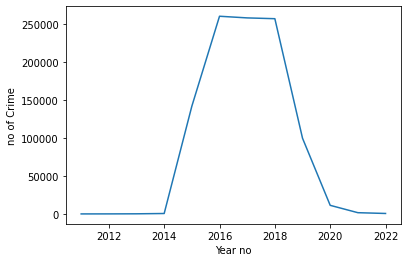

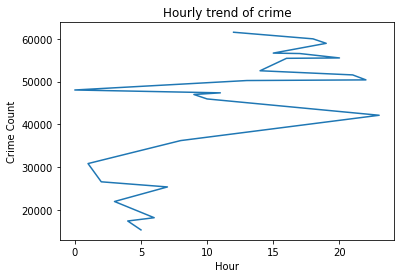

In [ ]:
# Year wise crime plot

import matplotlib.pyplot as plt
year_wise_crime = chicago_crime_merged.groupBy(year(col('Date')).alias('Year')).count().orderBy('Year').toPandas()
plt.plot(year_wise_crime['Year'], year_wise_crime['count'])
plt.xlabel('Year no')
plt.ylabel('no of Crime')
plt.show()

# showing that which hour of the day crime is highest with a line plot
hourly_crime_count = chicago_crime_merged.groupBy(hour('Date').alias('Hour')).count()
hourly_crime_count = hourly_crime_count.orderBy('count', ascending=False)
hourly_crime_count_df = hourly_crime_count.toPandas()
plt.plot(hourly_crime_count_df['Hour'], hourly_crime_count_df['count'])
plt.xlabel('Hour')
plt.ylabel('Crime Count')
plt.title('Hourly trend of crime')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

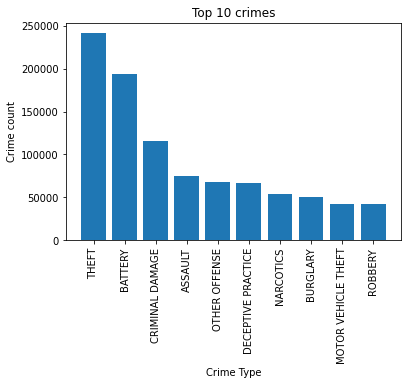

In [ ]:
#ploting top ten crimes as a bar chart

top_10_crimes = chicago_crime_merged.groupBy('Primary Type').count().orderBy('count', ascending=False).limit(10).toPandas()
plt.bar(top_10_crimes['Primary Type'], top_10_crimes['count'])
plt.xticks(rotation=90)
plt.title('Top 10 crimes')
plt.xlabel('Type')
plt.ylabel('Crime count')
plt.show
